import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [1]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math, json, pickle
from scipy.ndimage.measurements import label as labelconn
import argparse, pprint, shutil, logging, time, timeit
from pathlib import Path
import cv2
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from collections import namedtuple


import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

# %load_ext autoreload
# %autoreload 2




def copyDirectory(src, dest):
    try:
        shutil.copytree(src, dest)
    # Directories are the same
    except shutil.Error as e:
        print('Directory not copied. Error: %s' % e)
    # Any error saying that the directory doesn't exist
    except OSError as e:
        print('Directory not copied. Error: %s' % e)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.7.1


In [2]:
# wind to class name/description

path_to_folder = './synset'
filename = 'words.txt'
wind2name = {}
with open(path.join(path_to_folder, filename)) as fp:    
    line = True
    while line:
        line = fp.readline()
        line = line.strip()
        if len(line)<1: break
        
        curwind = line[:len('n15299367')]
        line = line[len('n15299367'):]
        line = line.strip()
        
        if curwind in wind2name:
            print(curwind, line)
            wind2name[curwind] = line
        else:
            wind2name[curwind] = line
        
print('total #classes: ', len(wind2name))

total #classes:  82115


total pairs:  75850
16693 parents have children.
74389 children have at least one parent.
5 1
402 1


Text(0.5, 0, 'class ID sorted by their #children')

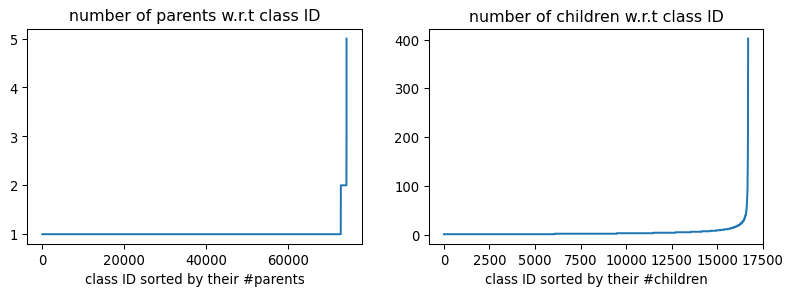

In [3]:
# parent-child pairs

path_to_folder = './synset'
filename = 'wordnet.is_a.txt'  # parent child
parentList = []
childList = []
parent2children = {}
child2parents = {}
with open(path.join(path_to_folder, filename)) as fp:    
    line = True
    while line:
        line = fp.readline()
        line = line.strip()
        if len(line)<1: break
        parentName, childName = line.split(' ')
        parentList.append(parentName) 
        childList.append(childName)
        
        if parentName in parent2children:
            parent2children[parentName].append(childName)
        else:
            parent2children[parentName] = [childName]
            
        if childName in child2parents:
            child2parents[childName].append(parentName)
        else:
            child2parents[childName] = [parentName]
        

numParentsPerChild = []
for key in child2parents:
    numParentsPerChild.append(len(child2parents[key]))
numChildrenPerParent = []
for key in parent2children:
    numChildrenPerParent.append(len(parent2children[key]))

    
print('total pairs: ', len(parentList))
print('{} parents have children.'.format(len(parent2children)))
print('{} children have at least one parent.'.format(len(child2parents)))

print(max(numParentsPerChild), min(numParentsPerChild))
print(max(numChildrenPerParent), min(numChildrenPerParent))



plt.figure(figsize=(10,3), dpi=95)
np_hist = np.asarray(numParentsPerChild)
sort_idx = np.argsort(np_hist)
plt.subplot(1,2,1)
plt.plot(np_hist[sort_idx])
plt.title('number of parents w.r.t class ID')
plt.xlabel('class ID sorted by their #parents')

np_hist = np.asarray(numChildrenPerParent)
sort_idx = np.argsort(np_hist)
plt.subplot(1,2,2)
plt.plot(np_hist[sort_idx])
plt.title('number of children w.r.t class ID')
plt.xlabel('class ID sorted by their #children')

In [4]:
# ImageNet-1K class wind

path_to_folder = './synset'
filename = 'imagenet1K_wind.txt'
imagenet1K_wind2name = {}
imagenet1K_child2parent = {}
imagenet1K_parent2children = {}


cnt_noChildren = 0
leafClasses = []
with open(path.join(path_to_folder, filename)) as fp:    
    line = True
    while line:
        curwind = fp.readline()
        curwind = curwind.strip()
        if len(curwind)<1: break
        
        if curwind in wind2name:
            imagenet1K_wind2name[curwind] = wind2name[curwind]
        else:
            print(curwind)
        
        if curwind in parent2children:
            imagenet1K_parent2children[curwind] = parent2children[curwind]
        else:
            leafClasses.append(curwind)
            #print('{:03d} no children '.format(cnt_noChildren), curwind)
            cnt_noChildren += 1
            
        if curwind in child2parents:
            imagenet1K_child2parent[curwind] = child2parents[curwind]
        else:
            print('no parents ', curwind) 
            
print('{} classes in total'.format(len(imagenet1K_wind2name)))
print('{} classes are leaves.'.format(cnt_noChildren))

1000 classes in total
650 classes are leaves.


In [5]:
# check if all ImageNet-1K leaf classes have parents
for curLeafClass in leafClasses:
    if curLeafClass not in child2parents:
        print(curLeafClass)
print('Great! All leaf classes have parents.')

Great! All leaf classes have parents.


In [6]:
# check if all ImageNet-1K classes have parents
for curclass in imagenet1K_wind2name:
    if curclass not in child2parents:
        print(curclass)
print('Great! All classes have parents.')

Great! All classes have parents.


In [7]:
# check if any classes are parents to any of the rest classes within the 1K classes
cnt = 0
for curparentclass in imagenet1K_wind2name:
    for curchildclass in imagenet1K_wind2name:
        if curparentclass==curchildclass:
            continue
            #print(cnt, curchildclass)
        if curchildclass in child2parents and curparentclass in child2parents[curchildclass]:
            print('a direct parent-child pair is found!')
            
        if curparentclass in parent2children and curchildclass in parent2children[curparentclass]:
            print('a direct child-parent pair is found!')
            
print('Sweet! There is no direct parent-child pairs in the 1K classes.')

Sweet! There is no direct parent-child pairs in the 1K classes.


In [8]:
# check if any ImageNet-1K classes have multiple parents
cnt = 1
removedWinds = {}
for curclass in imagenet1K_wind2name:
    numOfParents = len(child2parents[curclass])
    if numOfParents >1:
        removedWinds[curclass] = imagenet1K_wind2name[curclass]
        print('#{} {} has {} parents   name: {}'.format(cnt, curclass, numOfParents, imagenet1K_wind2name[curclass]))
        cnt += 1
        for elm in child2parents[curclass]:
            print('\t{}: {}'.format(elm, wind2name[elm]))

#1 n03770679 has 2 parents   name: minivan
	n03896419: passenger van
	n02958343: car, auto, automobile, machine, motorcar
#2 n03854065 has 2 parents   name: organ, pipe organ
	n04586932: wind instrument, wind
	n03614532: keyboard instrument
#3 n02916936 has 2 parents   name: bulletproof vest
	n04531873: vest, waistcoat
	n02862048: body armor, body armour, suit of armor, suit of armour, coat of mail, cataphract
#4 n04389033 has 3 parents   name: tank, army tank, armored combat vehicle, armoured combat vehicle
	n02740533: armored vehicle, armoured vehicle
	n03764276: military vehicle
	n04464852: tracked vehicle
#5 n03876231 has 2 parents   name: paintbrush
	n02730265: applicator, applier
	n02908217: brush
#6 n03776460 has 2 parents   name: mobile home, manufactured home
	n04467099: trailer, house trailer
	n03546340: housing, lodging, living accommodations
#7 n04552348 has 2 parents   name: warplane, military plane
	n03510583: heavier-than-air craft
	n03764276: military vehicle
#8 n034785

In [9]:
# we don't remove the classes which have more than one parent. We simply arbitrarily choose one to define the ontology.
# for elm in removedWinds:
#     if elm in imagenet1K_wind2name:
#         del imagenet1K_wind2name[elm]
    
print('{} classes are subject to be removed for simplification.'.format(len(removedWinds)))    
print('{} classes are remaining for experiments.'.format(len(imagenet1K_wind2name)))

38 classes are subject to be removed for simplification.
1000 classes are remaining for experiments.


In [10]:
# creating a full path for a class to the entity root
cnt = 0
imagenet1K_fullpath2root = {}
for curclass in imagenet1K_wind2name:
    imagenet1K_fullpath2root[curclass] = []
    flag = True
    tmpclass = curclass
    flag_ambiguousParents = False
    while flag:
        if tmpclass in child2parents and len(child2parents[tmpclass])==1:
            imagenet1K_fullpath2root[curclass].append(tmpclass)
            tmpclass = child2parents[tmpclass][0]
        elif tmpclass not in child2parents:
            imagenet1K_fullpath2root[curclass].append(tmpclass)
            flag = False
        else:
            imagenet1K_fullpath2root[curclass].append(tmpclass)
            tmpclass = child2parents[tmpclass][0]
            flag_ambiguousParents = True        
    print('{:3d} {} has root class {}:{}'.format(cnt, curclass, tmpclass, wind2name[tmpclass]))
    cnt += 1
    if flag_ambiguousParents:
        print('\tThis class have multiple parents!')
        

  0 n02108551 has root class n00001740:entity
	This class have multiple parents!
  1 n03627232 has root class n00001740:entity
  2 n04548362 has root class n00001740:entity
  3 n03838899 has root class n00001740:entity
  4 n04258138 has root class n00001740:entity
  5 n02978881 has root class n00001740:entity
  6 n07860988 has root class n00001740:entity
  7 n02489166 has root class n00001740:entity
  8 n03786901 has root class n00001740:entity
  9 n03770679 has root class n00001740:entity
	This class have multiple parents!
 10 n03877472 has root class n00001740:entity
	This class have multiple parents!
 11 n04366367 has root class n00001740:entity
 12 n02089078 has root class n00001740:entity
	This class have multiple parents!
 13 n03710721 has root class n00001740:entity
	This class have multiple parents!
 14 n03482405 has root class n00001740:entity
 15 n01924916 has root class n00001740:entity
 16 n02787622 has root class n00001740:entity
 17 n02109047 has root class n00001740:enti

longest length:  19
shorted legnth:  5


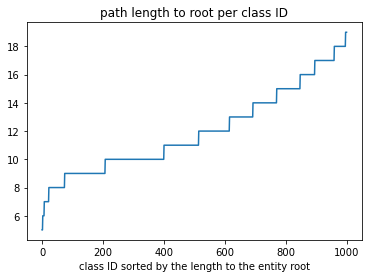

In [11]:
# obtain path from entity root to every class
pathLengthPerCls = []

imagenet1K_fullpathFromRoot = {}
for curclass in imagenet1K_wind2name:
    if curclass not in imagenet1K_fullpath2root:
        print(curclass)
    imagenet1K_fullpathFromRoot[curclass] = imagenet1K_fullpath2root[curclass].copy()
    imagenet1K_fullpathFromRoot[curclass].reverse()    
    pathLengthPerCls.append(len(imagenet1K_fullpathFromRoot[curclass]))
    
    
    
print('longest length: ', max(pathLengthPerCls))
print('shorted legnth: ', min(pathLengthPerCls))
    
np_hist = np.asarray(pathLengthPerCls)
sort_idx = np.argsort(np_hist)
plt.plot(np_hist[sort_idx])
plt.title('path length to root per class ID')
plt.xlabel('class ID sorted by the length to the entity root');

In [12]:
print(len(imagenet1K_fullpath2root[curclass]))
for elm in imagenet1K_fullpath2root[curclass]:
    print('{}:{}'.format(elm, wind2name[elm]))

13
n01978287:Dungeness crab, Cancer magister
n01976957:crab
n01976146:decapod crustacean, decapod
n01974773:crustacean
n01767661:arthropod
n01905661:invertebrate
n00015388:animal, animate being, beast, brute, creature, fauna
n00004475:organism, being
n00004258:living thing, animate thing
n00003553:whole, unit
n00002684:object, physical object
n00001930:physical entity
n00001740:entity


In [13]:
for elm in imagenet1K_fullpathFromRoot[curclass]:
    print('{}:{}'.format(elm, wind2name[elm]))

n00001740:entity
n00001930:physical entity
n00002684:object, physical object
n00003553:whole, unit
n00004258:living thing, animate thing
n00004475:organism, being
n00015388:animal, animate being, beast, brute, creature, fauna
n01905661:invertebrate
n01767661:arthropod
n01974773:crustacean
n01976146:decapod crustacean, decapod
n01976957:crab
n01978287:Dungeness crab, Cancer magister


In [14]:
list_classes_per_level = {}
ontologyPath = {}
tmpFullPathFromRoot = copy.deepcopy(imagenet1K_fullpathFromRoot)
flag_unfinished = True
cnt_finishedClasses = 0
L=0
while flag_unfinished:
    list_classes_per_level[L] = []
    for curclass in imagenet1K_wind2name:
        if len(tmpFullPathFromRoot[curclass])>0:
            tmp = tmpFullPathFromRoot[curclass][0]
            tmpFullPathFromRoot[curclass].remove(tmp)
            if tmp not in list_classes_per_level[L]:
                list_classes_per_level[L].append(tmp)
            if len(tmpFullPathFromRoot[curclass])==0:
                cnt_finishedClasses+=1
            if tmp not in ontologyPath:
                ontologyPath[tmp] = []
            if len(tmpFullPathFromRoot[curclass])>0:
                ontologyPath[tmp].append(tmpFullPathFromRoot[curclass][0])
                
        else:
            continue
    L+=1
    if cnt_finishedClasses==1000:
        flag_unfinished = False
        
        
        
cnt = 0
key2rm = []
for elm in ontologyPath:
    tmp = set(ontologyPath[elm])
    ontologyPath[elm] = list(tmp)
    #if len(ontologyPath[elm])==0:
    #    print('{}:{}'.format(cnt, elm))
    #    cnt+=1
    if len(ontologyPath[elm])==1:
        key2rm.append(elm)
        #print('{}:{}'.format(cnt, elm))
        cnt+=1
        
print('{} winds will be removed'.format(len(key2rm)))

449 winds will be removed


In [15]:
old2newMapping = {}
for elm in ontologyPath:
    if len(ontologyPath[elm])==1:
        old2newMapping[elm] = None
        newkey = ontologyPath[elm][0]
        while 0<len(ontologyPath[newkey])<2:
            newkey = ontologyPath[newkey][0]
        old2newMapping[elm] = newkey

print('{} winds will suppressed along the tree'.format(len(old2newMapping)))


tmp_ontologyPath = copy.deepcopy(ontologyPath)

for curkey in tmp_ontologyPath:
    for i in range(len(tmp_ontologyPath[curkey])):
        elm = tmp_ontologyPath[curkey][i]
        if elm in old2newMapping:
            tmp_ontologyPath[curkey][i] = old2newMapping[elm]  
cnt = 0
for elm in key2rm:
    if len(tmp_ontologyPath[elm])!=1:
        print('{:3d} error -- {}'.format(cnt, tmp_ontologyPath[elm]))
        cnt+=1
    del tmp_ontologyPath[elm]
    
print('{} classes in total'.format(len(tmp_ontologyPath)))    

449 winds will suppressed along the tree
1365 classes in total


In [16]:
# DFS
class DFSTREE:
    def __init__(self, treeDict=None, rootName=''):
        self.allpaths = {}
        self.tree = treeDict
        self.rootName = rootName
        self.dfs_search(self.rootName, [])
    def dfs_search(self, curnode, curpath):
        if self.tree[curnode]==[]:
            self.allpaths[curnode] = curpath+[curnode]
            return
        for elm in self.tree[curnode]:
            self.dfs_search(elm, curpath+[curnode])
            
AllPaths = DFSTREE(treeDict=tmp_ontologyPath, rootName=list_classes_per_level[0][0])
AllPaths = AllPaths.allpaths
print('{} paths in total, exactly for all the 1000 classes.'.format(len(AllPaths)))

longestPath = 0
longestPath_class = ''

for elm in AllPaths:
    if len(AllPaths[elm])>longestPath:
        longestPath = len(AllPaths[elm])
        longestPath_class = elm
print('longest path is {}, to the class {}:{}'.format(longestPath, longestPath_class, wind2name[longestPath_class]))

for elm in AllPaths[longestPath_class]:
    print('\t {}:{}'.format(elm, wind2name[elm]))

1000 paths in total, exactly for all the 1000 classes.
longest path is 17, to the class n02102040:English springer, English springer spaniel
	 n00001740:entity
	 n00001930:physical entity
	 n00002684:object, physical object
	 n00003553:whole, unit
	 n00004475:organism, being
	 n00015388:animal, animate being, beast, brute, creature, fauna
	 n01471682:vertebrate, craniate
	 n01861778:mammal, mammalian
	 n01886756:placental, placental mammal, eutherian, eutherian mammal
	 n02075296:carnivore
	 n02083346:canine, canid
	 n02084071:dog, domestic dog, Canis familiaris
	 n02087122:hunting dog
	 n02098550:sporting dog, gun dog
	 n02101108:spaniel
	 n02101861:springer spaniel, springer
	 n02102040:English springer, English springer spaniel


In [17]:
from treelib import Node, Tree

myTree = Tree()
rootNodeID = list_classes_per_level[0][0]
myTree.create_node('{}:{}'.format(rootNodeID, wind2name[rootNodeID]), list_classes_per_level[0][0])  # root node


def recursiveTreeConstruction(myTree, parentNode, ontologyPath):
    for elm in ontologyPath[parentNode]:
        myTree.create_node('{}:{}'.format(elm, wind2name[elm]), elm, parent=parentNode)
        recursiveTreeConstruction(myTree, elm, ontologyPath)        

recursiveTreeConstruction(myTree, list_classes_per_level[0][0], ontologyPath)


filename2save = 'ImageNet-tree.txt'
fn = open(filename2save,'w')
fn.write('')
fn.close()
myTree.save2file(filename2save)

myTree.show()

n00001740:entity
├── n00001930:physical entity
│   ├── n00002684:object, physical object
│   │   ├── n00003553:whole, unit
│   │   │   ├── n00004258:living thing, animate thing
│   │   │   │   └── n00004475:organism, being
│   │   │   │       ├── n00007846:person, individual, someone, somebody, mortal, soul
│   │   │   │       │   ├── n09613191:contestant
│   │   │   │       │   │   └── n10439851:player, participant
│   │   │   │       │   │       └── n09835506:ballplayer, baseball player
│   │   │   │       │   ├── n09626238:peer, equal, match, compeer
│   │   │   │       │   │   └── n09816771:associate
│   │   │   │       │   │       └── n10401829:participant
│   │   │   │       │   │           └── n10148035:groom, bridegroom
│   │   │   │       │   └── n10072708:explorer, adventurer
│   │   │   │       │       └── n10019552:diver, frogman, underwater diver
│   │   │   │       │           └── n10565667:scuba diver
│   │   │   │       ├── n00015388:animal, animate being, beast, brute,

# time-period 0
---
all leaves before layer 5, and nodes at layer 5

In [52]:
orderedWindList = []
for idx, curkey in enumerate(AllPaths):
    orderedWindList.append(curkey)

In [53]:
# removeBeforeLevel = 0
# tmp_AllPaths = copy.deepcopy(AllPaths)
# key2rm = []
# for idx, curkey in enumerate(tmp_AllPaths):
#     if len(AllPaths[curkey])<=removeBeforeLevel+1:
#         key2rm.append(curkey)
#         #print(idx, len(AllPaths[curkey]))
# for elm in key2rm:
#     del tmp_AllPaths[elm]
    
# print('{} classes are removed'.format(len(key2rm)))

The current task is 56-way classification


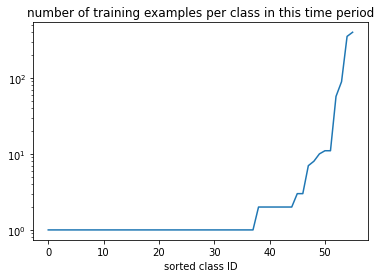

In [51]:
numPerFineCls = 1000
tmp_AllPaths = copy.deepcopy(AllPaths)

L = 5 # level 0-5, level0 is entity
LevelThreshList = np.ones((len(AllPaths),), dtype=np.uint8)*L

TP0_windList = {} # wind: fine-grained classes
for idx, curkey in enumerate(orderedWindList):
    curL = LevelThreshList[idx]
    
    if len(tmp_AllPaths[curkey])<=curL+1:
        TP0_windList[curkey] = [curkey]
        continue
    superclass_wind = tmp_AllPaths[curkey][curL]
    if superclass_wind in TP0_windList:
        TP0_windList[superclass_wind].append(curkey)
    else:
        TP0_windList[superclass_wind] = [curkey]
    
print('The current task is {}-way classification'.format(len(TP0_windList)))


clsWindList = []
freqPerCls = []
for curkey in TP0_windList:
    freqPerCls.append(len(TP0_windList[curkey])*numPerFineCls)
    clsWindList.append(curkey)
    
    
np_freqPerCls = np.asarray(freqPerCls)
np_clsWindList = np.asarray(clsWindList)
sort_idx = np.argsort(np_freqPerCls)
np_freqPerCls_sorted = np_freqPerCls[sort_idx]
np_clsWindList_sorted = np_clsWindList[sort_idx]
plt.plot(np_freqPerCls_sorted/numPerFineCls)
plt.yscale('log')
plt.title('number of training examples per class in this time period')
plt.xlabel('sorted class ID');

In [41]:
specialCareWindList = np_clsWindList_sorted[-7:]

for idx in range(len(LevelThreshList)):
    if orderedWindList in 

specialCareWindList = np_clsWindList_sorted[-7:]

In [50]:
np_freqPerCls_sorted

array([  1000,   1000,   1000,   1000,   1000,   1000,   1000,   1000,
         1000,   1000,   1000,   1000,   1000,   1000,   1000,   1000,
         1000,   1000,   1000,   1000,   1000,   1000,   1000,   1000,
         1000,   1000,   1000,   1000,   1000,   1000,   1000,   1000,
         1000,   1000,   1000,   1000,   1000,   1000,   2000,   2000,
         2000,   2000,   2000,   2000,   2000,   3000,   3000,   7000,
         8000,  10000,  11000,  11000,  57000,  89000, 351000, 398000])

In [40]:
print(np_freqPerCls_sorted[-7:], np_clsWindList_sorted[-7:])


for idx, wind in enumerate(np_clsWindList_sorted[-7:]):
    print(wind, wind2name[wind])




[ 10000  11000  11000  57000  89000 351000 398000] ['n07705931' 'n07570720' 'n03528263' 'n04341686' 'n03122748' 'n03575240'
 'n00015388']
n07705931 edible fruit
n07570720 nutriment, nourishment, nutrition, sustenance, aliment, alimentation, victuals
n03528263 home appliance, household appliance
n04341686 structure, construction
n03122748 covering
n03575240 instrumentality, instrumentation
n00015388 animal, animate being, beast, brute, creature, fauna


[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 2000 2000 2000 2000
 2000 2000 2000 3000]


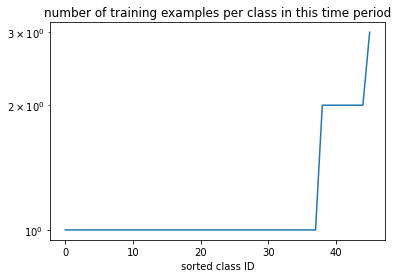

In [22]:
t = 10
plt.plot(np_freqPerCls_sorted[:-t]/numPerFineCls)
plt.yscale('log')
plt.title('number of training examples per class in this time period')
plt.xlabel('sorted class ID');

print(np_freqPerCls_sorted[:-t])

In [65]:
tmp = np.argmax(freqPerCls)
freqPerCls[tmp], clsWindList[tmp], wind2name[clsWindList[tmp]]

(130000, 'n02083346', 'canine, canid')

In [69]:
myTree.subtree('n02083346').show()

n02083346:canine, canid
├── n02084071:dog, domestic dog, Canis familiaris
│   ├── n02085374:toy dog, toy
│   │   ├── n02085620:Chihuahua
│   │   ├── n02085782:Japanese spaniel
│   │   ├── n02085936:Maltese dog, Maltese terrier, Maltese
│   │   ├── n02086079:Pekinese, Pekingese, Peke
│   │   ├── n02086240:Shih-Tzu
│   │   ├── n02086346:toy spaniel
│   │   │   ├── n02086478:English toy spaniel
│   │   │   │   └── n02086646:Blenheim spaniel
│   │   │   └── n02086910:papillon
│   │   └── n02087046:toy terrier
│   ├── n02087122:hunting dog
│   │   ├── n02087394:Rhodesian ridgeback
│   │   ├── n02087551:hound, hound dog
│   │   │   ├── n02088094:Afghan hound, Afghan
│   │   │   ├── n02088238:basset, basset hound
│   │   │   ├── n02088364:beagle
│   │   │   ├── n02088466:bloodhound, sleuthhound
│   │   │   ├── n02088632:bluetick
│   │   │   ├── n02088839:coonhound
│   │   │   │   └── n02089078:black-and-tan coonhound
│   │   │   ├── n02089555:foxhound
│   │   │   │   ├── n02089867:Walker houn

# time-period 1
---
all leaves before layer 10, and nodes at layer 5

The current task is 921-way classification


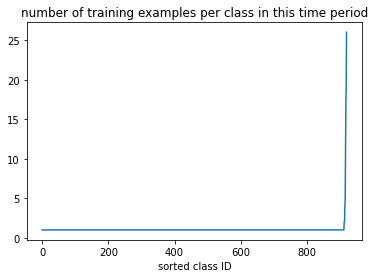

In [70]:
numPerFineCls = 1000

L = 13 # level 0-5, level0 is entity

TP0_windList = {} # wind: fine-grained classes
for curkey in tmp_AllPaths:
    if len(tmp_AllPaths[curkey])<=L+1:
        TP0_windList[curkey] = [curkey]
        continue
    superclass_wind = tmp_AllPaths[curkey][L]
    if superclass_wind in TP0_windList:
        TP0_windList[superclass_wind].append(curkey)
    else:
        TP0_windList[superclass_wind] = [curkey]
    
print('The current task is {}-way classification'.format(len(TP0_windList)))


freqPerCls = []
for curkey in TP0_windList:
    freqPerCls.append(len(TP0_windList[curkey])*numPerFineCls)
    
np_freqPerCls = np.asarray(freqPerCls)
np_clsWindList = np.asarray(clsWindList)
sort_idx = np.argsort(np_freqPerCls)
np_freqPerCls_sorted = np_freqPerCls[sort_idx]
plt.plot(np_freqPerCls_sorted/1000)
plt.title('number of training examples per class in this time period')
plt.xlabel('sorted class ID');

# time-period 2
---
all leaves

The current task is 1000-way classification


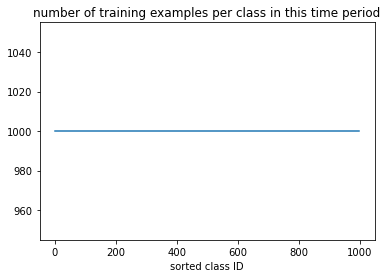

In [67]:
numPerFineCls = 1000

L = 27 # level 0-5, level0 is entity

TP0_windList = {} # wind: fine-grained classes
for curkey in tmp_AllPaths:
    if len(tmp_AllPaths[curkey])<=L+1:
        TP0_windList[curkey] = [curkey]
        continue
    superclass_wind = tmp_AllPaths[curkey][L]
    if superclass_wind in TP0_windList:
        TP0_windList[superclass_wind].append(curkey)
    else:
        TP0_windList[superclass_wind] = [curkey]
    
print('The current task is {}-way classification'.format(len(TP0_windList)))


freqPerCls = []
for curkey in TP0_windList:
    freqPerCls.append(len(TP0_windList[curkey])*numPerFineCls)
    
np_hist = np.asarray(freqPerCls)
sort_idx = np.argsort(np_hist)
np_hist_sorted = np_hist[sort_idx]
plt.plot(np_hist_sorted)
plt.title('number of training examples per class in this time period')
plt.xlabel('sorted class ID');